### Natcha Jangphiphatnawit 63340500031

# HOMEWORK 5: TEXT CLASSIFICATION
In this homework, you will create models to classify texts from TRUE call-center. There are two classification tasks:
1. Action Classification: Identify which action the customer would like to take (e.g. enquire, report, cancle)
2. Object Classification: Identify which object the customer is referring to (e.g. payment, truemoney, internet, roaming) 

In this homework, you are asked to do the following tasks:
1. Data Cleaning
2. Preprocessing data for keras
3. Build and evaluate a model for "action" classification
4. Build and evaluate a model for "object" classification
5. Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 


Note: we have removed phone numbers from the dataset for privacy purposes. 

In [224]:
# from google.colab import drive
# drive.mount('/content/drive')

In [225]:
# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/clean-phone-data.csv", "/content/clean-phone-data.csv")

## 1. Import Libs

In [257]:
# %matplotlib inline
import pandas
import sklearn
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt

from collections import defaultdict

# import deepcut
from pythainlp.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 2. Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

In [227]:
phone_df = pandas.read_csv('dataset/clean-phone-data.csv')
# phone_df = pandas.read_csv('/content/drive/MyDrive/NLP/HW_3/dataset/clean-phone-data.csv')

Let's preview the data.

In [228]:
# Show the top 5 rows
display(phone_df.head())
# Summarize the data
phone_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## 3. Data cleaning

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes for object and 10 unique labels for action that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

Also note that, there are 13389 unqiue sentence utterances from 16175 utterances. You have to clean that too!

### #TODO 1: 
You will have to remove unwanted label duplications as well as duplications in text inputs. 
Also, you will have to trim out unwanted whitespaces from the text inputs. 
This shouldn't be too hard, as you have already seen it in the demo.



In [229]:
display(phone_df.describe())
display(phone_df.Object.unique())
display(phone_df.Action.unique())

,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

In [230]:
# TODO1: Data cleaning
clean_df = phone_df.copy()

### 3.1 Trim white space

Remove space at starting and ending in each sentences

In [231]:
clean_df["Sentence Utterance_strip"] = (clean_df["Sentence Utterance"].str.strip()).str.lower().copy()

### 3.2 Fixing Label Duplication and Data Duplication

- Change all alphabet in lables into lower case.
- Remove some instance that have already appeared in dataset.

In [232]:
#change into lower case
clean_df['clean_Action'] = clean_df['Action'].str.lower().copy()
clean_df['clean_Object'] = clean_df['Object'].str.lower().copy()

#remove duplicate instances
clean_df = clean_df.drop_duplicates("Sentence Utterance_strip", keep="first")

#visualize result
display(clean_df.head())
display(clean_df.describe())

print('Action------------------------')
display(clean_df.Action.unique())
display(clean_df.clean_Action.unique())
print([e for e in list(clean_df.Action.unique()) if e not in list(clean_df.clean_Action.unique())])

print('Object------------------------')
display(clean_df.Object.unique())
display(clean_df.clean_Object.unique())
print([e for e in list(clean_df.Object.unique()) if e not in list(clean_df.clean_Object.unique())])

,Sentence Utterance,Action,Object,Sentence Utterance_strip,clean_Action,clean_Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment,<phone_number_removed> ผมไปจ่ายเงินที่ counter...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,report,phone_issues


,Sentence Utterance,Action,Object,Sentence Utterance_strip,clean_Action,clean_Object
count,13362,13362,13362,13362,13362,13362
unique,13362,10,32,13362,8,26
top,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,service,<phone_number_removed> ผมไปจ่ายเงินที่ counter...,enquire,service
freq,1,8540,2102,1,8643,2105


Action------------------------


array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

array(['enquire', 'report', 'cancel', 'buy', 'activate', 'request',
       'garbage', 'change'], dtype=object)

['Enquire', 'Report']
Object------------------------


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'ringtone', 'rate',
       'loyalty_card', 'Idd', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'],
      dtype=object)

['nonTrueMove', 'TrueMoney', 'Payment', 'Idd', 'Balance', 'Service', 'Loyalty_card']


## 4. Data Preparation

### #TODO 2: Preprocessing data for Keras
You will be using Tensorflow 2 keras in this assignment. Please show us how you prepare your data for keras.
Don't forget to split data into train and test sets (+ validation set if you want)

In [233]:
# TODO2: Preprocessing data for Keras

### 4.1 Drop unusing column in dataframe

In [234]:
clean_finish_df = (clean_df.drop(labels=['Sentence Utterance', 'Action', 'Object'], axis=1)).copy()
display(clean_finish_df.head())
display(clean_finish_df.describe())

,Sentence Utterance_strip,clean_Action,clean_Object
0,<phone_number_removed> ผมไปจ่ายเงินที่ counter...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,report,phone_issues


,Sentence Utterance_strip,clean_Action,clean_Object
count,13362,13362,13362
unique,13362,8,26
top,<phone_number_removed> ผมไปจ่ายเงินที่ counter...,enquire,service
freq,1,8643,2105


### 4.2 Create dictionary for action labels and object labels
Create action dictionary and object dictionary
- label to number
- number to label

In [235]:
#create numpy arrary for action and object labels
action_label = clean_finish_df.clean_Action.unique()
object_label = clean_finish_df.clean_Object.unique()

#Action map
action_to_num_map = dict(zip(action_label, range(len(action_label))))
num_to_action_map = dict(zip(range(len(action_label)), action_label))

#Object map
object_to_num_map = dict(zip(object_label, range(len(object_label))))
num_to_object_map = dict(zip(range(len(object_label)), object_label))

#Visualize to check
print("Action Map ->", len(action_to_num_map), "classes")
display(action_to_num_map)

print("Object Map", len(object_to_num_map), "classes")
display(object_to_num_map)

Action Map -> 8 classes


{'enquire': 0,
 'report': 1,
 'cancel': 2,
 'buy': 3,
 'activate': 4,
 'request': 5,
 'garbage': 6,
 'change': 7}

Object Map 26 classes


{'payment': 0,
 'package': 1,
 'suspend': 2,
 'internet': 3,
 'phone_issues': 4,
 'service': 5,
 'nontruemove': 6,
 'balance': 7,
 'detail': 8,
 'bill': 9,
 'credit': 10,
 'promotion': 11,
 'mobile_setting': 12,
 'iservice': 13,
 'roaming': 14,
 'truemoney': 15,
 'information': 16,
 'lost_stolen': 17,
 'balance_minutes': 18,
 'idd': 19,
 'garbage': 20,
 'ringtone': 21,
 'rate': 22,
 'loyalty_card': 23,
 'contact': 24,
 'officer': 25}

### 4.3 Prepare Dataset
- For training action classification
- For training object classification

In [236]:
data = clean_finish_df.to_numpy()
print(data.shape)
display(data)

(13362, 3)


array([['<phone_number_removed> ผมไปจ่ายเงินที่ counter services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท',
        'enquire', 'payment'],
       ['internet ยังความเร็วอยุ่เท่าไหร ครับ', 'enquire', 'package'],
       ['ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ', 'report',
        'suspend'],
       ...,
       ['ยอดเงินเหลือเท่าไหร่ค่ะ', 'enquire', 'balance'],
       ['ยอดเงินในระบบ', 'enquire', 'balance'],
       ['สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ', 'enquire', 'package']],
      dtype=object)

In [237]:
data[:,1] = np.vectorize(action_to_num_map.get)(data[:,1]) 
data[:,2] = np.vectorize(object_to_num_map.get)(data[:,2]) 
display(data)

array([['<phone_number_removed> ผมไปจ่ายเงินที่ counter services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท',
        0, 0],
       ['internet ยังความเร็วอยุ่เท่าไหร ครับ', 0, 1],
       ['ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ', 1, 2],
       ...,
       ['ยอดเงินเหลือเท่าไหร่ค่ะ', 0, 7],
       ['ยอดเงินในระบบ', 0, 7],
       ['สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ', 0, 1]], dtype=object)

#### - For training action classification
Prepare dataset for training action classification model has steps following:
1. Find keywords : analyze keywords in text of each action class by visualize some instance in that class and count frequency of word in sentences of each classes, then select top 20 words of each classes for being features
2. Create features : apply keyword to be features in dataset
3. Split into training set and testing set

##### 1. Find keywords

In [238]:
def show_first_in_label(first, select_label, label_idx, num_map):
    print("Showing label \"%s\"" % num_map[select_label])
    select = data[data[:, label_idx] == select_label, 0]
    for i in range(min(first, len(select))):
        print(i, select[i])
    print("")

In [239]:
first_three = 3
number_of_classes = 8
for i in range(number_of_classes):
    show_first_in_label(first_three, i, 1, num_to_action_map)

Showing label "enquire"
0 <phone_number_removed> ผมไปจ่ายเงินที่ counter services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท
1 internet ยังความเร็วอยุ่เท่าไหร ครับ
2 พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง โกลไล

Showing label "report"
0 ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
1 ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโทรออกไม่ได้คะ แต่เล่นเนตได้คะ
2 <phone_number_removed> ไปชำระค่าบริการช้า เน็ตตัด แต่พี่ไปชำระค่าบริการแล้วค่ะ แต่ยังใช้ไม่ได้ค่ะ

Showing label "cancel"
0 <phone_number_removed> จะยกเลิกข้อความนะคะ
1 <phone_number_removed> มี sms อะไรไม่รู้อ่ะค่ะ จะยกเลิกอ่ะค่ะ
2 <phone_number_removed> ใช้เบอร์เล่นอินเตอร์เน็ตอยู่ มันเป็นแอร์การ์ด จะยกเลิกอ่ะครับ

Showing label "buy"
0 <phone_number_removed> เป็นเติมเงินนะคะ เดี๋ยวนี้วันหมดอายุ ต้องขอต่ออีกหรือไม่คะ
1 internet 1k ที่สมัครไว้ใช้งานหมดแล้ว สามารถสมัครใหม่ได้หรือเปล่าครับ
2 sms ที่เคยสมัครไว้มันจะหายไปด้วยมั้ย <phone_number_removed> ที่สมัครเอาไว้เป็นหวยอ่ะครับ ที่สมัครไว้เห็นว่

In [240]:
#function count word in each classes
def create_keywords_dict(label_map, data, label_idx):
    keywords_dict = dict()

    #ignore some words which do not have importance meaning
    except_word = [' ','ผม', 'ค่ะ', 'คะ', 'ครับ', 'จะ', 'ว่า', 'ที่', 'มัน', 'อ่ะ', 'ของ', 'มา', 'นี้', 'หนู', 'พี่', 'บี', '_']

    for c in label_map.keys():
        sub_dict = defaultdict(lambda: 0)

        list_s = list(data[np.where(data[:,label_idx] == label_map[c])][:, 0])

        for s in list_s:
            sentence_tokenize = word_tokenize(s, engine="longest")

            for w in sentence_tokenize:
                if w not in except_word:
                  sub_dict[w] = sub_dict[w]+1

        # sort sub dict
        sorted_sub_dict = {}
        sorted_keys = sorted(sub_dict, key=sub_dict.get, reverse=True)
        for w in sorted_keys:
            sorted_sub_dict[w] = sub_dict[w]

        keywords_dict[c] = sorted_sub_dict

    return keywords_dict

In [241]:
action_keymap = create_keywords_dict(action_to_num_map, data, 1)

In [242]:
# function get most frequency words in each classes to be feature
def select_keywords(keywords_dict, top_key):
    list_keywords = []
    for c in keywords_dict.keys():
        if top_key < len(keywords_dict[c]):
            list_keywords += list(keywords_dict[c].keys())[:top_key]
        else:
            list_keywords += list(keywords_dict[c].keys())
    return list(set(list_keywords))

In [243]:
action_keywords = select_keywords(action_keymap, 20)
print("Total selected keywords:", len(action_keywords))
print(action_keywords[:])

Total selected keywords: 77
['คือ', 'เป็น', 'บริการ', 'ได้', 'ยอด', 'ค่าบริการ', 'เบอร์', 'จ่าย', 'สอบถาม', 'ให้', 'ใคร', 'ซื้อ', 'ตัด', 'ชำระ', 'โดน', 'การ', 'ยกเลิก', 'โปรโมชั่น', 'แพคเกจ', 'โทรศัพท์', 'sms', 'ข้อความ', 'เค้า', 'ศูนย์', 'โทร', 'วัน', 'ช่วย', 'ไป', 'แต่', 'แจ้ง', 'ทรู', 'ไอโฟน', 'ที่อยู่', 'เติม', 'อะไร', 'เนี่ย', 'ดู', 'รอ', 'แพ็คเกจ', 'โปร', 'ไม่', 'ใช้', 'สัญญาณ', 'ต้อง', 'ขอ', 'ทรูมูฟ', 'สาย', 'เสีย', 'เลย', 'ยัง', 'เปิด', 'ทำไม', 'หน่อย', 'เปลี่ยน', 'อินเตอร์เน็ต', 'เน็ต', 'บาท', 'ต้องการ', 'ถ้า', 'เครื่อง', 'เมื่อกี้', 'ออก', 'มี', 'ช็อป', 'ระงับ', 'เต', 'แล้ว', 'ซิม', 'เสริม', 'พอดี', 'เงิน', 'สมัคร', 'ถูก', 'ทราบ', 'อยาก', 'หาย', 'รายวัน']


In [244]:
action_list = [action_keywords for i in range(data.shape[0])]
action_key_arr = np.array(action_list)

##### 2. Create Feature

In [245]:
#function generate feature by apply selected keywords list to each instance
def gen_keywords_feature(string, keywords):
    result = np.zeros(len(keywords))
    for index, keyword in enumerate(keywords):
        if keyword in string:
            result[index] = 1
    return result

In [246]:
#create input features in sentences
action_feature = np.array(list(map(gen_keywords_feature, data[:,0], action_key_arr)))
action_feature = action_feature.astype(int)

#create output label in action classification
action_label = data[:, 1].astype(int)
action_label = to_categorical(action_label, num_classes=8)

print("Action Data")
print("Data shape", action_feature.shape)
print("label shape", action_label.shape)

Action Data
Data shape (13362, 77)
label shape (13362, 8)


In [247]:
#check preprocessing data

idx_check = 124

print("Feature Check")
print(data[idx_check,0])

print(action_feature[idx_check])

id = np.where(action_feature[idx_check] == 1)
print([w for i, w in enumerate(action_keywords) if i in list(id[0])])
print(list(id[0]))

print("\nLabel Check")
print(action_label[idx_check])
print(data[idx_check,1])
print(num_to_action_map[data[idx_check,1]])

Feature Check
เครื่องถูกระงับอีกและ
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0]
['เครื่อง', 'ระงับ', 'ถูก']
[59, 64, 72]

Label Check
[0. 1. 0. 0. 0. 0. 0. 0.]
1
report


##### 3. Spilt into training set and testing set

In [248]:
action_x_train, action_x_test, action_y_train, action_y_test = train_test_split(action_feature, action_label,
                                                                                 train_size=0.8, random_state=27,
                                                                                 shuffle=True)

print(action_x_train.shape, action_y_train.shape)
print(action_x_test.shape, action_y_test.shape)

(10689, 77) (10689, 8)
(2673, 77) (2673, 8)


#### - For training object classification
Prepare dataset for training object classification model has steps following:
1. Find keywords : analyze keywords in text of each object class by visualize some instance in that class and count frequency of word in sentences of each classes, then select top 20 words of each classes for being features
2. Create features : apply keyword to be features in dataset
3. Split into training set and testing set

##### Find keywords

In [249]:
first_three = 2
number_of_classes = 26
for i in range(number_of_classes):
    show_first_in_label(first_three, i, 2, num_to_object_map)

Showing label "payment"
0 <phone_number_removed> ผมไปจ่ายเงินที่ counter services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท
1 <phone_number_removed> เติมบัตรไม่ได้เลย

Showing label "package"
0 internet ยังความเร็วอยุ่เท่าไหร ครับ
1 <phone_number_removed> เป็นเติมเงินนะคะ เดี๋ยวนี้วันหมดอายุ ต้องขอต่ออีกหรือไม่คะ

Showing label "suspend"
0 ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
1 <phone_number_removed> หมายเลขนี้โดนระงับบริการเหรอค่ะ

Showing label "internet"
0 พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง โกลไล
1 <phone_number_removed> เค้าบอกจะส่งรหัสเน็ตมาให้ แต่ยังไม่ได้ส่งมาเลยค่ะ

Showing label "phone_issues"
0 ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโทรออกไม่ได้คะ แต่เล่นเนตได้คะ
1 <phone_number_removed> ไปชำระค่าบริการช้า เน็ตตัด แต่พี่ไปชำระค่าบริการแล้วค่ะ แต่ยังใช้ไม่ได้ค่ะ

Showing label "service"
0 *2222 ใช้งานยังไง ขอรายละเอียดการสมัครหน่อย
1 <phone_number_removed> จะยกเลิกข้อความนะคะ

Showing label "nontruemove"
0 <phone_number_re

In [250]:
object_keymap = create_keywords_dict(object_to_num_map, data, 2)

In [251]:
object_keywords = select_keywords(object_keymap, 20)
print("Total object keywords:", len(object_keywords))
print(object_keywords)

Total object keywords: 171
['ใน', 'ไวไฟ', 'เท่าไหร่', 'เป็น', 'คือ', 'บริการ', 'ได้', 'าร์ด', 'บัตรเติมเงิน', 'เร', 'ตั้งค่า', 'เอช', 'ยอด', 'เห็น', 'ค่าบริการ', 'ดี', 'คิด', 'เบอร์', 'จ่าย', 'สอบถาม', 'ทำ', 'ให้', 'ใคร', 'ซื้อ', 'ขอร้อง', 'ชำระ', 'ตัด', 'ได้รับ', 'เพลง', 'เข้า', 'เตื่', 'รหัส', 'มาหา', 'โดน', 'ลูกค้า', 'การ', 'เปลี่ยนเสียง', 'ยกเลิก', 'เช็ค', 'โปรโมชั่น', 'i', 'ค่า', 'ผ่าน', 'ก็', 'แพคเกจ', 'เอสเอ็มเอส', 'โทรศัพท์', 'ตั้ง', 'นี่', 'เกิน', 'ดา', 'sms', 'อน', 'ข้อความ', 'ใบ', 'เค้า', 'ศูนย์', 'แบ', 'โทร', 'ให้บริการ', 'กี่', 'ไป', 'แต่', 'แจ้ง', 'ดก', 'อะ', 'ทรู', 'ไอโฟน', 'ที่อยู่', 'เติม', 'ยังไง', 'ร็ค', 'เตือน', 'อะไร', 'เนี่ย', 'ยอดค้างชำระ', 'ขึ้น', 'ดู', 'เพิ่ม', 'จี', 'รอบ', 'รอ', 'ส่วนลด', 'โปร', 'ไม่', 'ใช้', 'เรื่อง', 'เดือน', 'บัตร', 'บิล', 'เอส', 'สัญญาณ', 'ฟรี', 'ขโมย', 'ต้อง', 'ขอ', '1331', 'กด', 'บ้าง', 'ทรูมูฟ', 'ตอนนี้', 'ละ', 'ริงโทน', 'สาย', 'true', 'เสีย', 'บ้าน', 'หา', 'ต่างประเทศ', 'เลย', 'เสียง', 'โอน', 'ยัง', 'เปิด', 'ใส่', 'ถาม', 'ทำไม', 'หน่อย

In [252]:
object_list = [object_keywords for i in range(data.shape[0])]
object_key_arr = np.array(object_list)

##### Create Feature

In [253]:
#input features in sentences
object_feature = np.array(list(map(gen_keywords_feature, data[:,0], object_key_arr)))
object_feature = object_feature.astype(int)
#output label in action classification
object_label = data[:, 2].astype(int)
object_label = to_categorical(object_label, num_classes=26)

print("Object Data")
print("Data shape", object_feature.shape)
print("label shape", object_label.shape)

Object Data
Data shape (13362, 171)
label shape (13362, 26)


In [255]:
#check preprocessing data

idx_check = 124

print("Feature Check")
print(data[idx_check,0])

print(object_feature[idx_check])

id = np.where(object_feature[idx_check] == 1)
print([w for i, w in enumerate(object_keywords) if i in list(id[0])])
print(list(id[0]))

print("\nLabel Check")
print(object_label[idx_check])
print(data[idx_check,2])
print(num_to_object_map[data[idx_check,1]])

Feature Check
เครื่องถูกระงับอีกและ
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
['ละ', 'เครื่อง', 'ระงับ', 'ถูก']
[101, 125, 144, 161]

Label Check
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
2
package


##### Split into training set and testing set

In [256]:
object_x_train, object_x_test, object_y_train, object_y_test = train_test_split(object_feature, object_label,
                                                                                 train_size=0.8, random_state=27,
                                                                                 shuffle=True)

print(object_x_train.shape, object_y_train.shape)
print(object_x_test.shape, object_y_test.shape)

(10689, 171) (10689, 26)
(2673, 171) (2673, 26)


## #TODO 3: Build and evaluate a model for "action" classification


In [ ]:
#TODO 3: Build and evaluate a model for "action" classification

### Create Model

In [148]:
def action_Model():
    inputs = Input(shape=(action_x_train.shape[1], ), dtype='int32')
    
    x = Dense(units=128, activation='relu')(inputs)
    x = Dropout(rate=0.2)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Dense(units=32, activation='relu')(x)
    x = Dense(units=action_y_train.shape[1], activation='relu')(x)
    x = Activation('softmax')(x)

    return Model(inputs=inputs, outputs=x)

action_cls = action_Model()
action_cls.summary()
action_opt = Adam(learning_rate=0.01)
action_cls.compile(loss="categorical_crossentropy", optimizer=action_opt, metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 77)]              0         
                                                                 
 dense_23 (Dense)            (None, 128)               9984      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 8)                 264 

### Train Model

In [149]:
action_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=0.0001, min_delta=0.011)
action_cls.fit(action_x_train, action_y_train, epochs=10, callbacks=action_scheduler)

Epoch 1/10
335/335 [==============================] - 2s 3ms/step - loss: 0.8650 - accuracy: 0.7425 - lr: 0.0100
Epoch 2/10
335/335 [==============================] - 1s 2ms/step - loss: 0.7224 - accuracy: 0.7750 - lr: 0.0100
Epoch 3/10
335/335 [==============================] - 1s 3ms/step - loss: 0.6779 - accuracy: 0.7859 - lr: 0.0100
Epoch 4/10
335/335 [==============================] - 1s 3ms/step - loss: 0.6643 - accuracy: 0.7861 - lr: 0.0100
Epoch 5/10
335/335 [==============================] - 1s 2ms/step - loss: 0.6574 - accuracy: 0.7883 - lr: 0.0100
Epoch 6/10
335/335 [==============================] - 1s 2ms/step - loss: 0.5992 - accuracy: 0.8015 - lr: 1.0000e-03
Epoch 7/10
335/335 [==============================] - 1s 2ms/step - loss: 0.5789 - accuracy: 0.8053 - lr: 1.0000e-03
Epoch 8/10
335/335 [==============================] - 1s 2ms/step - loss: 0.5659 - accuracy: 0.8091 - lr: 1.0000e-03
Epoch 9/10
335/335 [==============================] - 1s 2ms/step - loss: 0.5601 - a

### Evaluation

#### - Testing evaluation

In [310]:
action_result_train = action_cls.evaluate(action_x_train, action_y_train)
action_result_test = action_cls.evaluate(action_x_test, action_y_test)

print("train_loss:", action_result_train[0], "train_accuracy:", action_result_train[1])
print("test_loss:", action_result_test[0], "test_accuracy:", action_result_test[1])

84/84 [==============================] - 0s 2ms/step - loss: 0.7022 - accuracy: 0.7883
train_loss: 0.5192489624023438 train_accuracy: 0.8195341229438782
test_loss: 0.7021538615226746 test_accuracy: 0.7882528901100159


#### - Confusion Matrix

84/84 [==============================] - 0s 2ms/step


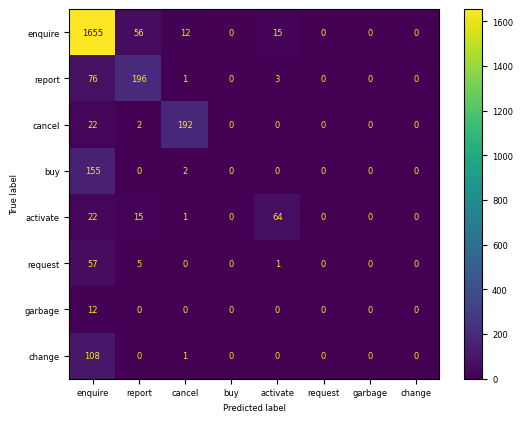

In [279]:
action_pred = np.argmax(action_cls.predict(action_x_test), axis=1)
cm_action = confusion_matrix(np.argmax(action_y_test, axis=1), action_pred)
action_classes = np.array(list(action_to_num_map.keys()))

plt.rcParams.update({'font.size': 6})

disp = ConfusionMatrixDisplay(confusion_matrix=cm_action, display_labels=action_classes)
disp.plot()
plt.show()

## #TODO 4: Build and evaluate a model for "object" classification



In [ ]:
#TODO 4: Build and evaluate a model for "object" classification

### Create Model

In [212]:
def object_Model():
    inputs = Input(shape=(object_x_train.shape[1], ), dtype='int32')
    
    x = Dense(units=256, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(units=64, activation='relu')(x)
    
    x = Dense(units=object_y_train.shape[1], activation='relu')(x)
    x = Activation('softmax')(x)

    return Model(inputs=inputs, outputs=x)

object_cls = object_Model()
object_cls.summary()
object_opt = Adam(learning_rate=0.01)
object_cls.compile(loss="categorical_crossentropy", optimizer=object_opt, metrics=['accuracy'])

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 171)]             0         
                                                                 
 dense_80 (Dense)            (None, 256)               44032     
                                                                 
 dropout_38 (Dropout)        (None, 256)               0         
                                                                 
 dense_81 (Dense)            (None, 128)               32896     
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_82 (Dense)            (None, 64)                8256      
                                                                 
 dense_83 (Dense)            (None, 26)                169

### Train Model

In [213]:
object_scheduler = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.0001)
object_cls.fit(object_x_train, object_y_train, epochs=15, callbacks=object_scheduler)

Epoch 1/15
335/335 [==============================] - 2s 4ms/step - loss: 1.7375 - accuracy: 0.5308 - lr: 0.0100
Epoch 2/15
335/335 [==============================] - 1s 3ms/step - loss: 1.4791 - accuracy: 0.6105 - lr: 0.0100
Epoch 3/15
335/335 [==============================] - 1s 3ms/step - loss: 1.3879 - accuracy: 0.6366 - lr: 0.0100
Epoch 4/15
335/335 [==============================] - 1s 3ms/step - loss: 1.3387 - accuracy: 0.6490 - lr: 0.0100
Epoch 5/15
335/335 [==============================] - 1s 3ms/step - loss: 1.2484 - accuracy: 0.6823 - lr: 0.0100
Epoch 6/15
335/335 [==============================] - 1s 3ms/step - loss: 1.2087 - accuracy: 0.6884 - lr: 0.0100
Epoch 7/15
335/335 [==============================] - 1s 3ms/step - loss: 1.1672 - accuracy: 0.7004 - lr: 0.0100
Epoch 8/15
335/335 [==============================] - 1s 3ms/step - loss: 1.1231 - accuracy: 0.7125 - lr: 0.0100
Epoch 9/15
335/335 [==============================] - 1s 3ms/step - loss: 1.0910 - accuracy: 0.7

### Evaluation

#### - Testing evaluation

In [309]:
object_result_train = object_cls.evaluate(object_x_train, object_y_train)
object_result_test = object_cls.evaluate(object_x_test, object_y_test)

print("\ntrain_loss:", object_result_train[0], "train_accuracy:", object_result_train[1])
print("test_loss:", object_result_test[0], "test_accuracy:", object_result_test[1])

84/84 [==============================] - 0s 2ms/step - loss: 1.7950 - accuracy: 0.6311

train_loss: 0.7459856271743774 train_accuracy: 0.8144821524620056
test_loss: 1.795049786567688 test_accuracy: 0.6311260461807251


#### - Confusion Matrix

84/84 [==============================] - 0s 2ms/step


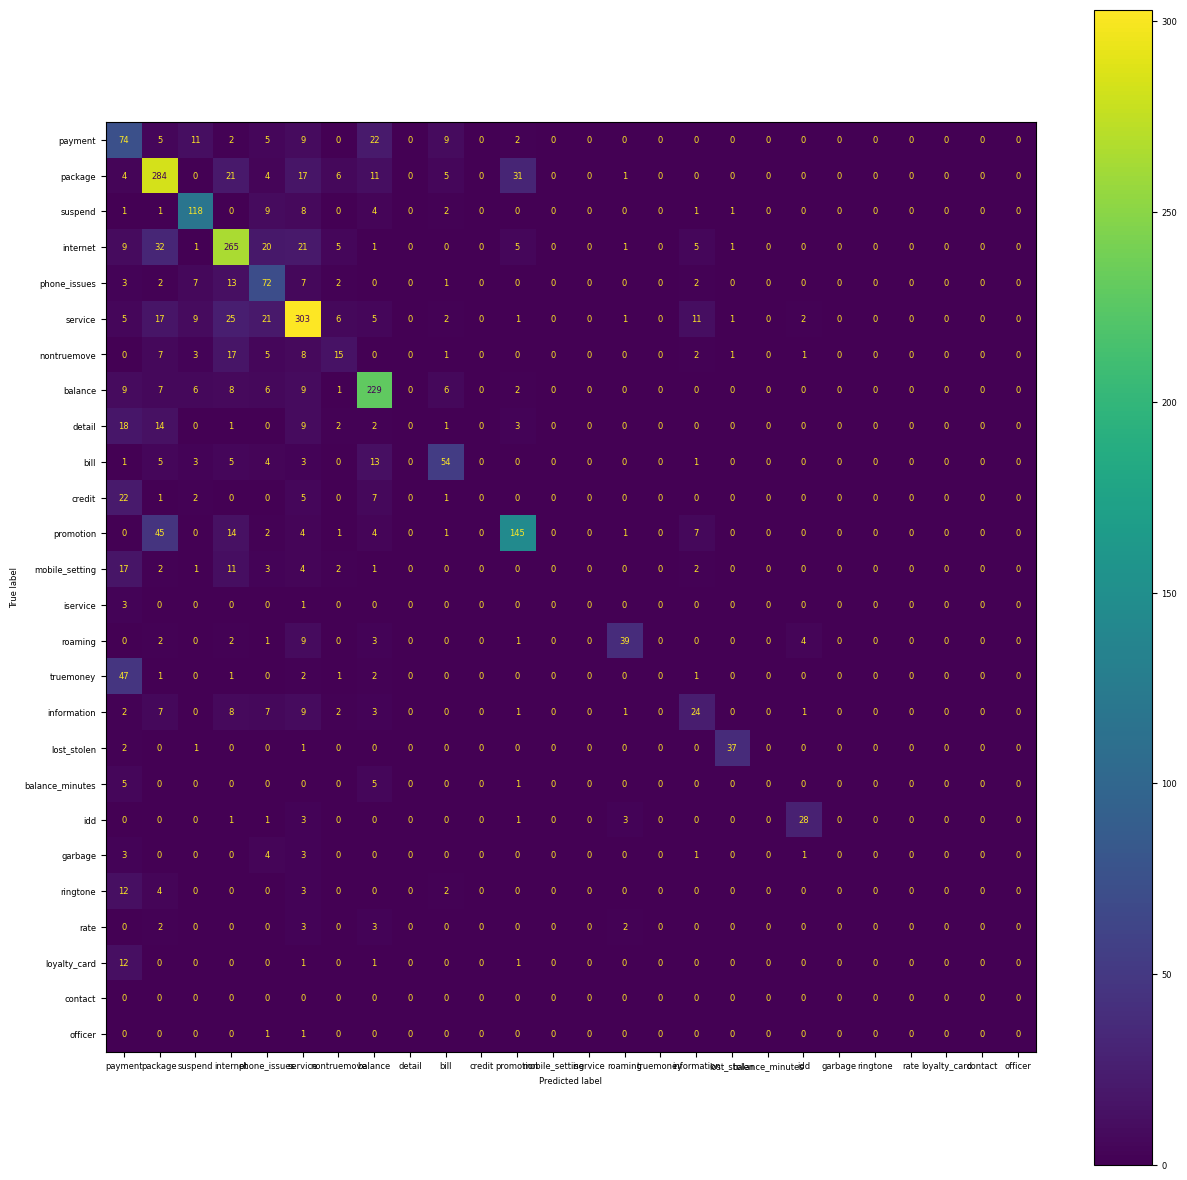

In [304]:
object_pred = np.argmax(object_cls.predict(object_x_test), axis=1)
object_classes = np.array(list(object_to_num_map.values()))
cm_object = confusion_matrix(np.argmax(object_y_test, axis=1), object_pred, labels=object_classes)
object_classes = np.array(list(object_to_num_map.keys()))

plt.rcParams.update({'font.size': 6})

disp = ConfusionMatrixDisplay(confusion_matrix=cm_object, display_labels=object_classes)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.show()

## #TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 

This can be a bit tricky, if you are not familiar with the Keras functional API. PLEASE READ these webpages(https://www.tensorflow.org/guide/keras/functional, https://keras.io/getting-started/functional-api-guide/) before you start this task.   

Your model will have 2 separate output layers one for action classification task and another for object classification task. 

This is a rough sketch of what your model might look like:
image --> https://drive.google.com/file/d/1r7M6tFyQDu6pJIxLd_fn2kBMjo_CWmUK/view?usp=share_link

In [ ]:
#TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go

### Create Model

In [215]:
def combine_Model():
    action_inputs = Input(shape=(action_x_train.shape[1],), name="action")
    object_inputs = Input(shape=(object_x_train.shape[1],), name="object")

    #Action model
    action_x = Dense(units=128, activation='relu')(action_inputs)
    action_x = Dropout(rate=0.2)(action_x)
    action_x = Dense(units=64, activation='relu')(action_x)
    action_x = Dropout(rate=0.1)(action_x)
    action_x = Dense(units=32, activation='relu')(action_x)
    
    action_x = Dense(units=action_y_train.shape[1], activation='relu')(action_x)
    action_pred = Activation('softmax', name="action_pred")(action_x)

    #Object model
    object_x = Dense(units=256, activation='relu')(object_inputs)
    object_x = Dropout(0.1)(object_x)
    object_x = Dense(units=128, activation='relu')(object_x)
    object_x = Dropout(0.1)(object_x)
    object_x = Dense(units=64, activation='relu')(object_x)
    
    object_x = Dense(units=object_y_train.shape[1], activation='relu')(object_x)
    object_pred = Activation('softmax', name="object_pred")(object_x)

    return Model(inputs=[action_inputs, object_inputs], 
                 outputs=[action_pred, object_pred])

In [220]:
combine_cls = combine_Model()
combine_cls.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 action (InputLayer)            [(None, 77)]         0           []                               
                                                                                                  
 object (InputLayer)            [(None, 171)]        0           []                               
                                                                                                  
 dense_92 (Dense)               (None, 128)          9984        ['action[0][0]']                 
                                                                                                  
 dense_96 (Dense)               (None, 256)          44032       ['object[0][0]']                 
                                                                                           

### Train Model

In [221]:
combine_opt = Adam(learning_rate=0.01)
combine_cls.compile(optimizer=combine_opt, 
                   loss={"action_pred": "categorical_crossentropy",
                         "object_pred": "categorical_crossentropy"},
                   metrics=['accuracy'])

In [222]:
combine_cls.fit({"action": action_x_train, "object": object_x_train},
                {"action_pred": action_y_train, "object_pred": object_y_train},
                epochs=10)

Epoch 1/10
335/335 [==============================] - 3s 4ms/step - loss: 2.5572 - action_pred_loss: 0.7461 - object_pred_loss: 1.8111 - action_pred_accuracy: 0.7737 - object_pred_accuracy: 0.5173
Epoch 2/10
335/335 [==============================] - 1s 4ms/step - loss: 2.1732 - action_pred_loss: 0.6259 - object_pred_loss: 1.5472 - action_pred_accuracy: 0.8077 - object_pred_accuracy: 0.5893
Epoch 3/10
335/335 [==============================] - 1s 4ms/step - loss: 1.9966 - action_pred_loss: 0.5451 - object_pred_loss: 1.4515 - action_pred_accuracy: 0.8257 - object_pred_accuracy: 0.6081
Epoch 4/10
335/335 [==============================] - 1s 3ms/step - loss: 1.9144 - action_pred_loss: 0.5097 - object_pred_loss: 1.4047 - action_pred_accuracy: 0.8351 - object_pred_accuracy: 0.6198
Epoch 5/10
335/335 [==============================] - 1s 4ms/step - loss: 1.8424 - action_pred_loss: 0.5004 - object_pred_loss: 1.3420 - action_pred_accuracy: 0.8396 - object_pred_accuracy: 0.6285
Epoch 6/10
335/

### Evaluation

In [307]:
combine_result_train = combine_cls.evaluate({"action": action_x_train, "object": object_x_train},
                                    {"action_pred": action_y_train, "object_pred": object_y_train})

combine_result_test = combine_cls.evaluate({"action": action_x_test, "object": object_x_test},
                                    {"action_pred": action_y_test, "object_pred": object_y_test})

print("\naction loss train:", combine_result_train[1], "action accuracy train", combine_result_train[3])
print("action loss test:", combine_result_test[1], "action accuracy test", combine_result_test[3])

print("\nobject loss train:", combine_result_train[2], "object accuracy train", combine_result_train[4])
print("object loss test:", combine_result_test[2], "object accuracy test", combine_result_test[4])

84/84 [==============================] - 0s 3ms/step - loss: 2.3279 - action_pred_loss: 0.5342 - object_pred_loss: 1.7936 - action_pred_accuracy: 0.8369 - object_pred_accuracy: 0.5829

action loss train: 0.34755948185920715 action accuracy train 0.8809991478919983
action loss test: 0.5342240333557129 action accuracy test 0.8368874192237854

object loss train: 1.1111341714859009 object accuracy train 0.7052109837532043
object loss test: 1.7936323881149292 object accuracy test 0.5828657150268555


## #Summary all of this notebook

### Data Cleaning
In data cleaning part, we have done the steps following:
1. Trim white space : Cut space at starting and ending of each sentences
2. Fixing label duplication and data (instance) duplication : There are some labels which are the same but spell with upper and lower case alphabet, so we need to rewrite it. And there are some duplicated instance which need to remove.

### Data Propressing
Prepare dataset for training action and object classification models have steps following:
1. Find keywords : Analyze keywords in text of each class by visualize some instance in that class and count frequency of word in sentences of each classes, then select popular words of each classes for being features.
2. Create features : Apply keywords to be features in dataset
3. Split into training set and testing set

### Action Classification Model

- Result of evaluation

|               | loss | accuracy |
|:-------------:|:----:|:--------:|
| training set  | 0.519| 0.819    |
| testing set   | 0.702| 0.788    |

- Analysis<br>
    From the result, the model does not appear to be overfitting or underfitting. In confusion matrix, you will see dataset is imbalance, with certain classes such as "request" and "garbage" being almost always predicted as "enquire", which is the majority class in this dataset. Additionally, the use of features may not be adequate to represent some of the classes well. So, to improve this model, we may need to identify new features that can accurately represent all classes and consider downsampling certain classes to achieve a more balanced dataset.

### Object Classification Model
- Result of eveluation

|               | loss | accuracy |
|:-------------:|:----:|:--------:|
| training set  | 0.745| 0.814    |
| testing set   | 1.795| 0.631    |

- Analysis<br>
    The results suggest that the model is overfitting, because the performance on the training set is considerably better than testing set. This may be due to the fact that there are 26 classes to predict, which is quite a large number compared to the amount of available data. So, when trying to represent the data using more features (171 features), the model may not be able to learn as effectively. And there is the same issue in the action classification model, where there are some classes with a significantly smaller number of samples than others.

### Combine Model
- Result of eveluation: Action

|               | loss | accuracy |
|:-------------:|:----:|:--------:|
| training set  | 0.347| 0.880    |
| testing set   | 0.534| 0.836    |

- Result of eveluation: Object

|               | loss | accuracy |
|:-------------:|:----:|:--------:|
| training set  | 1.111| 0.705    |
| testing set   | 1.793| 0.582    |

- Analysis
    The results are quite similar to those obtained from the separated model, as they have the same structure.